In [1]:
import time
import rawpy
import numpy as np
from matplotlib import pyplot
from scipy.ndimage.filters import convolve

RED_CH   = 0
GREEN_CH = 1
BLUE_CH  = 2

even = lambda x: x%2==0
odd  = lambda x: x%2!=0

def cfa_channel(row, column):
    """Return color channel of row,column pair based on the Bayer filter."""

    # CR2 CFA Pattern: [Red   , Green] <-- even rows: 0, 2, 4, ...
    #                  [Green , Blue]  <-- odd  rows: 1, 3, 5, ...
    # Note: Python is zero-indexed
    if even(row):
        if even(column):
            return GREEN_CH
        return RED_CH
    else:
        if even(column):
            return BLUE_CH
        return GREEN_CH

path = './scene_raw.CR2'
with rawpy.imread(path) as raw:
    # np array with raw intensities values
    print('Copying img array')
    img = raw.raw_image.copy()
    # get WB as shot by the camera
    camera_wb = raw.camera_whitebalance

# print some info
print(img.shape)
import scipy as sp
img = sp.misc.imresize(img, (250,250))
(h, w) = img.shape

pyplot.figure()
pyplot.imshow(img,cmap='gray')
pyplot.show()

print(h,w)


print('Start demosaicing - Bilinear interpolation')
start_time = time.time()

print('Building channel masks...')
# channels = dict((channel, np.zeros(img.shape)) for channel in 'RGB')
# print(channels)
# for channel, (y, x) in zip('RGGB', [(0, 0), (0, 1), (1, 0), (1, 1)]):
#     print(x,y)
#     channels[channel][y::2, x::2] = 1
# R_m, G_m, B_m = tuple(channels[c].astype(bool) for c in 'RGB')

def get_CFA_masks(shape):
    #print(shape)
    mask = np.zeros(shape)
    print(shape[0], shape[1])
    for i in range(0,shape[0]):
        for j in range(0, shape[1]):
            mask[i,j] = cfa_channel(i,j)
    return mask


cfa_mask = get_CFA_masks((h,w))
pyplot.imshow(cfa_mask)
pyplot.show()

R_m = cfa_mask==0.0
G_m = cfa_mask==1.0
B_m = cfa_mask==2.0



pyplot.figure()
pyplot.imshow(R_m)
pyplot.show()

pyplot.figure()
pyplot.imshow(B_m)
pyplot.show()

pyplot.figure()
pyplot.imshow(G_m)
pyplot.show()

ImportError: No module named rawpy

Running bilinear interpolation...


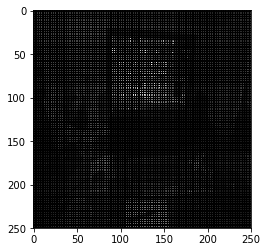

Stacking channels...


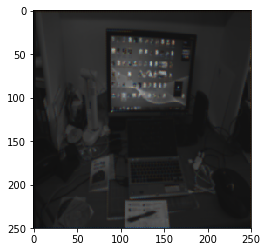

In [3]:
# convolution kernels
# green
H_G = np.asarray(
    [[0.0, 1.0, 0.0],
     [1.0, 4.0, 1.0],
     [0.0, 1.0, 0.0]]) / 4
# red/blue
H_RB = np.asarray(
    [[1.0, 2.0, 1.0],
     [2.0, 4.0, 2.0],
     [1.0, 2.0, 1.0]]) / 4

print('Running bilinear interpolation...')

pyplot.figure()
pyplot.imshow(img*R_m,cmap='gray')
pyplot.show()

from scipy import signal

R = convolve(img * R_m, H_RB)
G = convolve(img * G_m, H_G)
B = convolve(img * B_m, H_RB)
print('Stacking channels...')
rgb = np.dstack((R,G,B))

pyplot.figure()
pyplot.imshow(rgb)
pyplot.show()

('Elapsed time:', 5.657262086868286)
Normalizing from 0..65535 to 0..1 ...
White balancing...
('Reference white:', array([0.0305333 , 0.01562524, 0.02734417]))
Normalizing from 0..1 to 0..255 ...


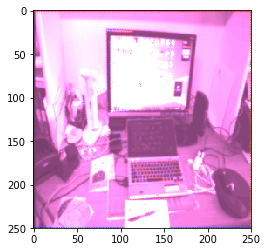

Applying gamma encoding (gamma = 1/2.2)...
Display final image...


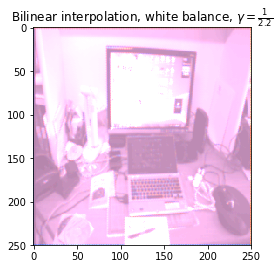

In [4]:
elapsed_time = time.time() - start_time
print('Elapsed time:', elapsed_time)


print('Normalizing from 0..65535 to 0..1 ...')
rgb = rgb - np.min(rgb)
rgb = rgb/np.float(np.max(rgb))

print('White balancing...')
white = np.array(camera_wb[:3])/65535
print('Reference white:', white)

final = rgb * white

print('Normalizing from 0..1 to 0..255 ...')
rgb = rgb * 255
final = final * 255

pyplot.figure()
pyplot.imshow(final, aspect='equal', interpolation='none')
pyplot.show()

print('Applying gamma encoding (gamma = 1/2.2)...')
final = final ** (1/2.2)

print("Display final image...")
pyplot.title(r'Bilinear interpolation, white balance, $\gamma = \frac{1}{2.2}$')
pyplot.imshow(final, aspect='equal', interpolation='none')

# Uncomment the following lines to show individual channels
# zeros = np.zeros(final.shape, dtype=final.dtype)
# red = final * R_m
# green = final * G_m
# blue = final * B_m
# pyplot.figure()
# pyplot.title('Red channel')
# pyplot.imshow(np.dstack((red, zeros, zeros)), aspect='equal', interpolation='none')
# pyplot.figure()
# pyplot.title('Green channel')
# pyplot.imshow(np.dstack((zeros, green, zeros)), aspect='equal', interpolation='none')
# pyplot.figure()
# pyplot.title('Blue channel')
# pyplot.imshow(np.dstack((zeros, zeros, blue)), aspect='equal', interpolation='none')

pyplot.show()